<a href="https://colab.research.google.com/github/Noznoc/access-classifier/blob/main/WIP_Exterior_Accessibility_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Binary Classifier of "Accessible" or "Inaccessible" Building Enterances
**Author:** Alex Lane and Julia Conzon <br>
**Date created:** 2021/03/18<br>
**Description:** Training an image classifier from scratch on the Mapillary API imagery collected on building enterances. This workflow follows the Classifier from [Scratch Keras tutorial](https://keras.io/examples/vision/image_classification_from_scratch/).

## Setup


Import the necessary Python packages for evaluation.

In [7]:
import sys # for importing directory
import tensorflow as tf # for modeling
from tensorflow import keras # for modeling
from keras.models import Sequential # following Wu et al. (2019) sequential model was used
from tensorflow.keras import layers
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Activation, BatchNormalization
import matplotlib.pyplot as plt # for visualizing images
import numpy as np
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

## Load the data: "Accessible" and "Inaccessible" dataset

Compile data from the Mapillary API, [scripts accessible in another notebook]()

Confirm folder of Mapillary API imagery exists. Subfolders should be `Accessible` and `Inaccessible`, which each contain the images that represent the category.


In [ ]:
!ls OSM_And_Mapillary_Sequence_Dataset

import os, random
import shutil

# Function that randomly moves image files based on source directory, destination directory and number of files wanting to move
def randomly_move_imgs(src_dir, dst_dir, n):
  file_list = os.listdir(src_dir)
  for j in range(n):
    img = random.choice(file_list)
    shutil.move(src_dir + img, dst_dir)

# Read "OSM_And_Mapillary_Sequence_Dataset/Accessible" folder randomly select n and move to "Test/Accessible" folder
n = 10
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Accessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible"
# randomly_move_imgs(src_dir, dst_dir, n)

# Read "OSM_And_Mapillary_Sequence_Dataset/Inaccessible" folder and randomly select n and move to "Test/Inaccessible" folder
n = 10
src_dir = "./OSM_And_Mapillary_Sequence_Dataset/Train/Inaccessible/"
dst_dir = "./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible"
# randomly_move_imgs(src_dir, dst_dir, n)

Model  Test  Train


## Preprocess Data


Steps includes standardizing the images to the same size (`image_size`). 

Keras `seed` command is an optional parameter to offer a random seed for shuffling and transforming the images to augment the dataset. 

In [8]:
#image_size = (256,256)
image_size = (512, 512)
batch_size_custom = 8

'''
num_k_folds = 10
fold_accuracies = []
fold_losses = []

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_custom,
    label_mode = 'binary',
)
'''

# Randomly assign to a train dataset (85%)
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_custom,
    label_mode = 'binary',
)


# Randomly assign to a validation dataset (15%)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size_custom,
    label_mode = 'binary'
)


# confirm classes
class_names = train_ds.class_names
print(class_names)

Found 824 files belonging to 2 classes.
Using 660 files for training.
Found 824 files belonging to 2 classes.
Using 164 files for validation.
['Accessible', 'Inaccessible']


# Preprocess and augment data

In [ ]:
image_size = (512, 512)
batch_size_custom = 32

train_aug_gen = ImageDataGenerator(
    validation_split = 0.2, 
    horizontal_flip=True,
    brightness_range = [0.7,1.3],
    zoom_range = 0.2,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    shear_range=0.2,
    rotation_range=20, 
    )

train_ds_gen = train_aug_gen.flow_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    subset="training",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size_custom,
    classes = ['Accessible','Inaccessible'],
    class_mode = 'binary',
)

valid_ds_gen = train_aug_gen.flow_from_directory(
    "OSM_And_Mapillary_Sequence_Dataset/Train",
    subset="validation",
    seed=1337,
    target_size=image_size,
    batch_size=batch_size_custom,
    classes = ['Accessible','Inaccessible'],
    class_mode = 'binary',
)

# confirm classes
#class_names = train_ds_gen.class_names
#print(class_names)

Found 660 images belonging to 2 classes.
Found 164 images belonging to 2 classes.


## Visualize Data

Label 1 is "inaccessible" and label 0 is "accessible".


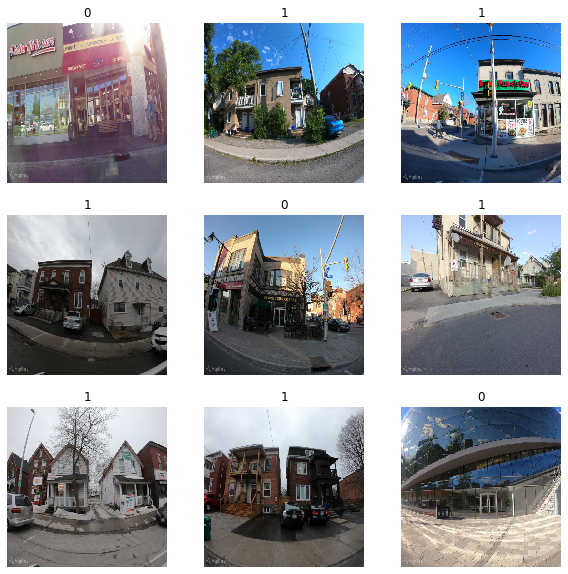

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Augmentation

Considering the small sample for training, the dataset will be augmented, that is randomly flipped horizontally, rotated, contrasted and zoomed. Order impacts the image gets distorted. Different tests were applied to identify an optimal augmentation, as seen below:

https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/


In [9]:
data_augmentation = keras.Sequential(
    [
        # Reminder, the order in which transformations are called significantly 
        # affects the final augmentation.
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomTranslation(0.2,0.2),
        layers.experimental.preprocessing.RandomZoom(0.3),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomContrast(0.1),
        layers.experimental.preprocessing.RandomHeight(0.3),
        layers.experimental.preprocessing.RandomWidth(0.3),
        layers.experimental.preprocessing.Resizing(512, 512),
    ]
)

Visualize the augmented samples:


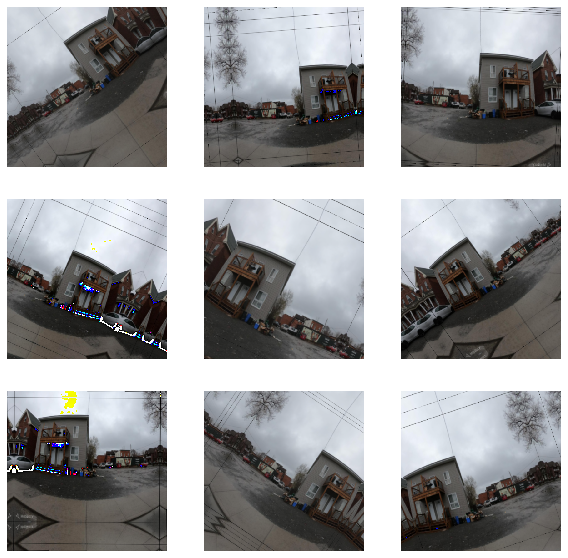

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
	plt.subplot(3, 3, i + 1)
	batch = train_ds_gen.next()
	image = batch[0].astype('uint8')
	plt.imshow(image[0])
plt.show()

## Configure Dataset

Following documentation from Keras creator, François Chollet, use buffered prefetching to yield data from disk without having I/O becoming blocking:


In [10]:
train_ds = train_ds.prefetch(buffer_size=32)
valid_ds = valid_ds.prefetch(buffer_size=32)


## Build Our Model

https://link.springer.com/article/10.1007/s11042-019-08453-9





Tensor("input_2:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("dense_3/Sigmoid:0", shape=(None, 1), dtype=float32)


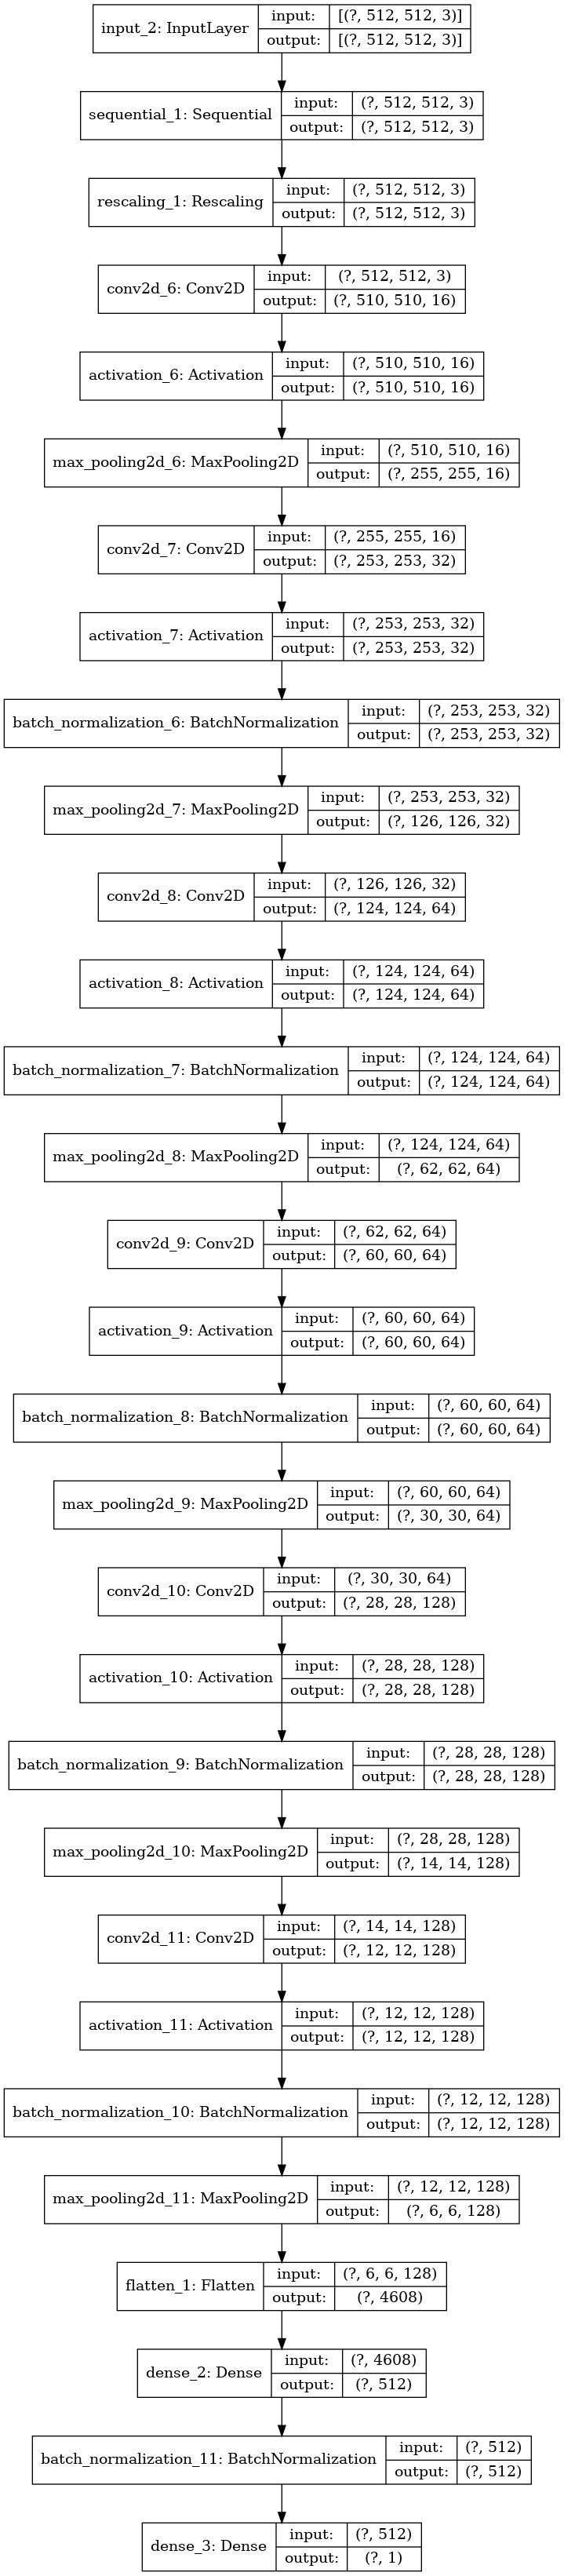

In [11]:
# MODEL ARCHITECTURES BY WU ET AL (2019):

# CNN2: CONV(64, 3), RELU, CONV(32, 3), RELU, POOL(2), CONV(64, 3), FC(128), RELU, FC(2), SOFTMAX.
# CNN3: [CONV(128, 3), RELU, POOL(2)], [CONV(64 3), RELU, POOL(2)], [CONV(32, 3), RELU, POOL(2)], DROPOUT(), RELU, FC(512), RELU, FC(2), SOFTMAX.
# CNN5: CONV(128, 3), RELU, CONV(128, 3), RELU, POOL(2), CONV(64, 3), DROPOUT(), RELU, CONV(64, 3), RELU, POOL(2), CONV(32, 3), DROPOUT(), RELU, POOL(2), FC(512), RELU, DROPOUT(), FC(256), RELU, FC(2), SOFTMAX

# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)
layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

# rescale the image to 1 and 0, not 255 RGB
layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

# Building blocks for CNN

layer = Conv2D(filters=16, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

#Build Our Model, but with more augmentations

Tensor("input_14:0", shape=(None, 512, 512, 3), dtype=float32)
Tensor("dense_27/Sigmoid:0", shape=(None, 1), dtype=float32)


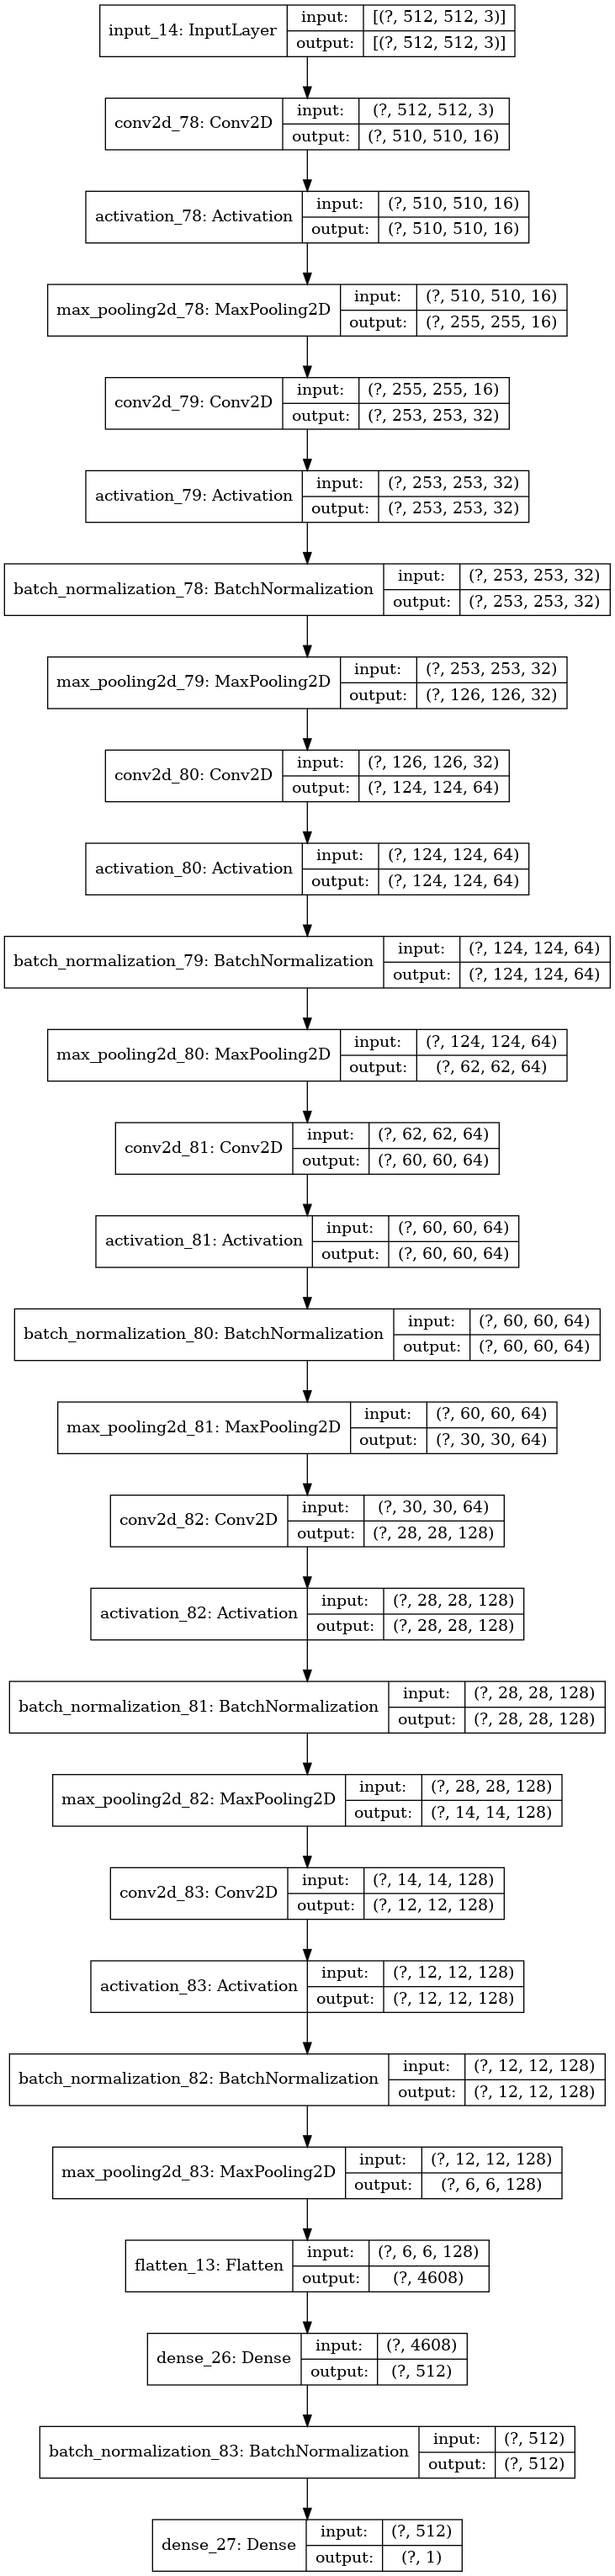

In [ ]:


# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)

# Building blocks for CNN

layer = Conv2D(filters=16, kernel_size=3)(inputs)
layer = Activation('relu')(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

# Build Modified "Wu CNN5" Model - so modified it's basically not Wu CNN5
Start off with a simple Sequential model, following Wu et al. (2019)
Their CNNs require an inordinate amount of memory for med-high image size

In [ ]:
# MODEL ARCHITECTURES BY WU ET AL (2019):

# CNN2: CONV(64, 3), RELU, CONV(32, 3), RELU, POOL(2), CONV(64, 3), FC(128), RELU, FC(2), SOFTMAX.
# CNN3: [CONV(128, 3), RELU, POOL(2)], [CONV(64 3), RELU, POOL(2)], [CONV(32, 3), RELU, POOL(2)], DROPOUT(), RELU, FC(512), RELU, FC(2), SOFTMAX.
# CNN5: CONV(128, 3), RELU, CONV(128, 3), RELU, POOL(2), CONV(64, 3), DROPOUT(), RELU, CONV(64, 3), RELU, POOL(2), CONV(32, 3), DROPOUT(), RELU, POOL(2), FC(512), RELU, DROPOUT(), FC(256), RELU, FC(2), SOFTMAX

# Model parameters
input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
num_classes = 2 # number of classes being defined

# Initialize model
inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
print(inputs)
layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

# rescale the image to 1 and 0, not 255 RGB
layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

# Building blocks for CNN

layer = Conv2D(filters=32, kernel_size=3)(layer)
layer = Activation('relu')(layer)
#layer = BatchNormalization()(layer)
#layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=64, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
#layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Conv2D(filters=128, kernel_size=3)(layer)
layer = Activation('relu')(layer)
layer = BatchNormalization(momentum=0.9)(layer)
layer = MaxPooling2D(pool_size = (2,2))(layer)

layer = Flatten()(layer)

layer = Dense(512, activation='relu')(layer)
#layer = Dropout(0.1)(layer)
layer = BatchNormalization(momentum=0.9)(layer)
#layer = Dense(256, activation='relu')(layer)
#layer = Dropout(0.1)(layer)
outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution

print(outputs)

# Initialize model with building blocks
model = keras.Model(inputs, outputs)

# Plot model architecture
keras.utils.plot_model(model, to_file='model.png', rankdir='TR', show_shapes='True')

# Print summary of model
# model.summary()

# Print each layer
# for layer in model.layers:
#   print(layer.output_shape)

# K-Fold Model - WIP
https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/#creating-a-keras-model-with-k-fold-cross-validation

In [ ]:


kfold = KFold(n_splits=num_k_folds, shuffle=True)

fold_counter = 1
for train, test in kfold.split():

    # Model parameters
    input_shape = image_size + (3,) # add RGB code of 3 to image shape for Keras Input() argument
    num_classes = 2 # number of classes being defined

    # Initialize model
    inputs = keras.Input(shape=input_shape) # establish inputs e.g., (180, 180, 3) is the width and height dimension and 3 represents RGB
    print(inputs)
    layer = data_augmentation(inputs) # first "layer" is augmented images that are called in the previous script

    # rescale the image to 1 and 0, not 255 RGB
    layer = layers.experimental.preprocessing.Rescaling(1.0 / 255)(layer)

    # Building blocks for CNN

    layer = Conv2D(filters=16, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=32, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=64, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=64, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=128, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Conv2D(filters=128, kernel_size=3)(layer)
    layer = Activation('relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    layer = MaxPooling2D(pool_size = (2,2))(layer)

    layer = Flatten()(layer)

    layer = Dense(512, activation='relu')(layer)
    layer = BatchNormalization(momentum=0.9)(layer)
    outputs = Dense(1, activation='sigmoid')(layer) # or use sigmoid to view probability distribution


    

# Train Model

Epoch 1/100
83/83 [==============================] - 26s 315ms/step - loss: 1.1167 - accuracy: 0.5894 - val_loss: 0.9197 - val_accuracy: 0.5549
Epoch 2/100
83/83 [==============================] - 27s 325ms/step - loss: 0.7735 - accuracy: 0.5970 - val_loss: 0.6728 - val_accuracy: 0.6707
Epoch 3/100
83/83 [==============================] - 27s 324ms/step - loss: 0.7456 - accuracy: 0.6121 - val_loss: 0.7462 - val_accuracy: 0.6463
Epoch 4/100
83/83 [==============================] - 28s 337ms/step - loss: 0.6216 - accuracy: 0.6818 - val_loss: 0.7316 - val_accuracy: 0.6707
Epoch 5/100
83/83 [==============================] - 28s 335ms/step - loss: 0.6250 - accuracy: 0.7045 - val_loss: 0.6329 - val_accuracy: 0.6829
Epoch 6/100
83/83 [==============================] - 27s 323ms/step - loss: 0.6249 - accuracy: 0.7045 - val_loss: 0.6698 - val_accuracy: 0.6768
Epoch 7/100
83/83 [==============================] - 28s 341ms/step - loss: 0.6525 - accuracy: 0.6576 - val_loss: 0.6476 - val_accuracy:

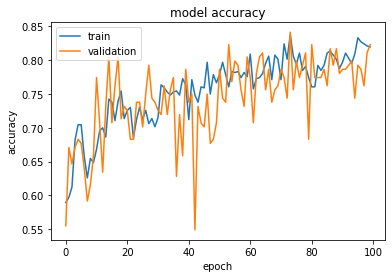

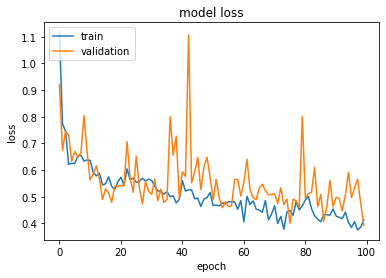

In [12]:
# Number of epochs
epochs = 100

# Add callbacks to log file
callbacks = [
    keras.callbacks.ModelCheckpoint("./OSM_And_Mapillary_Sequence_Data/Model/Epochs/100/{epoch}.h5"),
]

# Compile CNN, following default optimizer and loss function for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

from keras.callbacks import CSVLogger

# TO INTEGRATE FOR LOGGING ACCURACY: 
csv_logger = CSVLogger('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/epochs_100_batch8_training.log', separator=',', append=False)
# https://stackoverflow.com/questions/47843265/how-can-i-get-the-a-keras-models-history-after-loading-it-from-a-file-in-python
classifier = model.fit(train_ds, epochs=epochs, callbacks=csv_logger, validation_data=valid_ds, shuffle=True)

# This following visualization is taken from 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

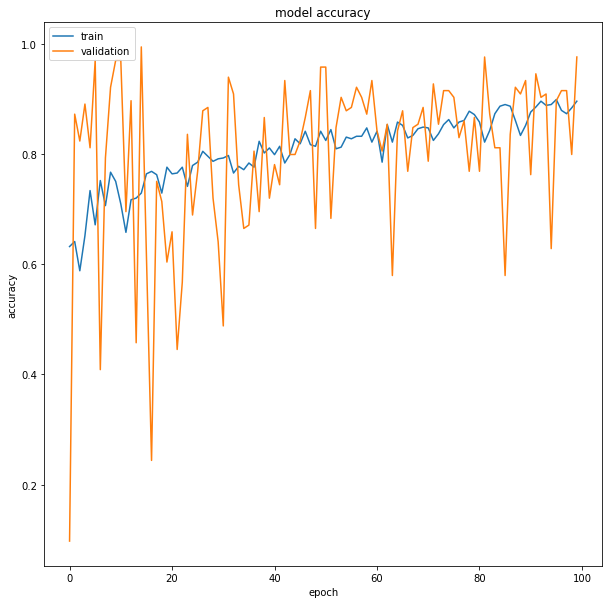

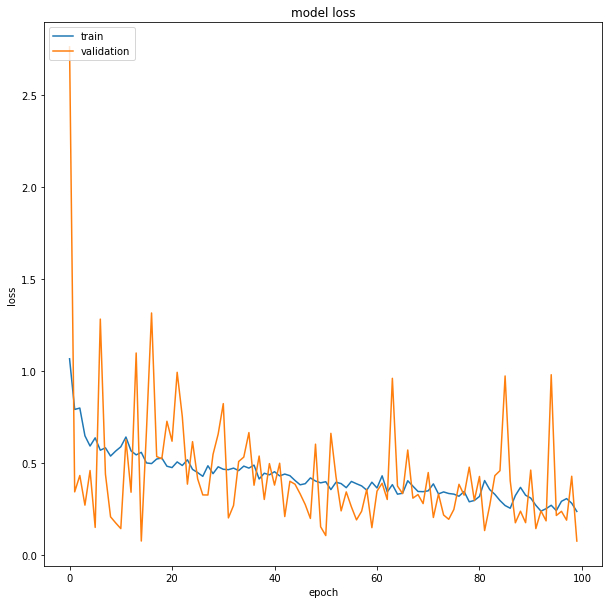

In [ ]:
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
#plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

In [54]:
model.evaluate(valid_ds)
#print(model.predict(valid_ds))
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045

Y_pred = model.predict(valid_ds, 164 // batch_size_custom+1)
print(Y_pred)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
#val = tf.concat([y for x, y in valid_ds], axis=0)
val = tf.concat([y for x, y in valid_ds], axis=0)
print(val)
print('Confusion Matrix')
print(confusion_matrix(y_pred, val))
'''
y_pred = model.predict(valid_ds, shuffle=False)

y_pred = [1 * (x[0]>=0.5) for x in Y_pred]

target = tf.concat([y for x, y in valid_ds], axis=0)

print(confusion_matrix(y_pred, target))
'''

print('Classification Report')
target_names = ['Accessible','Inaccessible']
print(classification_report(val, y_pred, target_names=target_names))

11/11 [==============================] - 5s 488ms/step - loss: 0.0780 - accuracy: 0.9756
[[0.996775  ]
 [0.99732876]
 [0.9999347 ]
 [0.9980082 ]
 [0.9104692 ]
 [0.99987495]
 [0.9998729 ]
 [0.99981576]
 [0.9995604 ]
 [0.9980805 ]
 [0.9993303 ]
 [0.9960984 ]
 [0.99918467]
 [0.9968669 ]
 [0.9974847 ]
 [0.98547375]
 [0.9997179 ]
 [0.99946433]
 [0.9994764 ]
 [0.9880896 ]
 [0.99937016]
 [0.99972063]
 [0.9997243 ]
 [0.9998437 ]
 [0.9963961 ]
 [0.99886346]
 [0.98892874]
 [0.9998436 ]
 [0.9998436 ]
 [0.9998865 ]
 [0.9998865 ]
 [0.9996462 ]
 [0.9996462 ]
 [0.9990879 ]
 [0.9990879 ]
 [0.9998367 ]
 [0.9998367 ]
 [0.9999665 ]
 [0.999997  ]
 [0.9999862 ]
 [0.9717773 ]
 [0.9140544 ]
 [0.9534141 ]
 [0.9924414 ]
 [0.9998574 ]
 [0.99971634]
 [0.9999497 ]
 [0.99994564]
 [0.99993396]
 [0.9999049 ]
 [0.99994326]
 [0.9987889 ]
 [0.7466903 ]
 [0.9719729 ]
 [0.9907279 ]
 [0.9295012 ]
 [0.9700042 ]
 [0.97962415]
 [0.99981314]
 [0.99861133]
 [0.9611576 ]
 [0.97070056]
 [0.9988727 ]
 [0.99990094]
 [0.9980254 ]
 

/home/student/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/student/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/student/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Training for "Our Model, but with more augmentations"

In [ ]:
# Number of epochs
epochs = 50

# Add callbacks to log file
callbacks = [
    keras.callbacks.ModelCheckpoint("OSM_And_Mapillary_Sequence_Data/Model/Epochs/{epoch}.h5"),
]

# Compile CNN, following default optimizer and loss function for binary classification
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

classifier = model.fit(
    train_ds_gen, 
    epochs=epochs, 
    callbacks=callbacks, 
    validation_data=valid_ds_gen, 
    shuffle=True,
    steps_per_epoch = 660//batch_size_custom,
    validation_steps = 164//batch_size_custom,
    )

#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
Y_pred = model.predict_generator(valid_ds_gen, 164 // batch_size_custom+1)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
print('Confusion Matrix')
print(confusion_matrix(valid_ds_gen.classes, y_pred))
print('Classification Report')
target_names = ['Accessible','Inaccessible']
print(classification_report(valid_ds_gen.classes, y_pred, target_names=target_names))

# This following visualization is taken from 
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
# summarize history for accuracy
plt.plot(classifier.history['accuracy'])
plt.plot(classifier.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(classifier.history['loss'])
plt.plot(classifier.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#https://gist.github.com/RyanAkilos/3808c17f79e77c4117de35aa68447045
Y_pred = model.predict_generator(valid_ds_gen, 164 // batch_size_custom+1)
y_pred = [1 * (x[0]>=0.5) for x in Y_pred]
print('Confusion Matrix')
print(confusion_matrix(valid_ds_gen.classes, y_pred))
print('Classification Report')
target_names = ['Accessible','Inaccessible']
print(classification_report(valid_ds_gen.classes, y_pred, target_names=target_names))

Confusion Matrix
[[37 45]
 [34 48]]
Classification Report
              precision    recall  f1-score   support

  Accessible       0.52      0.45      0.48        82
Inaccessible       0.52      0.59      0.55        82

    accuracy                           0.52       164
   macro avg       0.52      0.52      0.52       164
weighted avg       0.52      0.52      0.52       164



# Save Model

In [ ]:
model.save('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/200 Epoch 80-20 Overfit 94-87 w batch 16 & norm/')

INFO:tensorflow:Assets written to: ./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/200 Epoch 80-20 Overfit 94-87 w batch 16 & norm/assets


# Load Model

Alternatively, load a model instead of training a new one

In [ ]:
model = keras.models.load_model('./OSM_And_Mapillary_Sequence_Dataset/Model/Saved Models/100 Epoch 80-20 81-83 w batch 16 & norm')

# Test Model


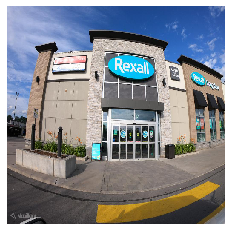

Staples 1595 Merivale Road 75.png
This image of building entrance is 98.96 percent accessible and 1.04 percent inaccessible.
✅ - This image has been correctly classified as accessible.



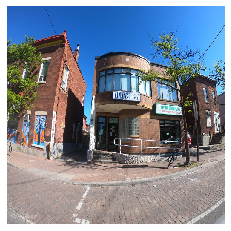

0245 -Q2FqoePMq5qkC4FM_IU6Q.png
This image of building entrance is 4.12 percent accessible and 95.88 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



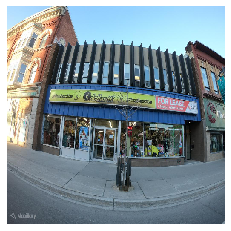

0566 QR6cBiunpB_PXCisWczWPw.png
This image of building entrance is 90.12 percent accessible and 9.88 percent inaccessible.
✅ - This image has been correctly classified as accessible.



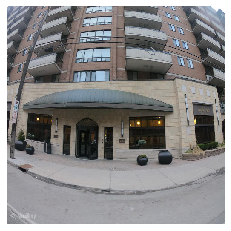

Albert at Bay Suite Hotel 435 Albert Street 0.png
This image of building entrance is 99.14 percent accessible and 0.86 percent inaccessible.
✅ - This image has been correctly classified as accessible.



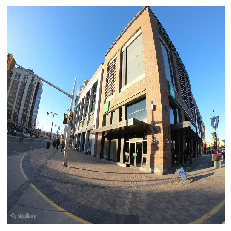

0009 A8-IT0RqrOz9YlybO7_UEg.png
This image of building entrance is 93.74 percent accessible and 6.26 percent inaccessible.
✅ - This image has been correctly classified as accessible.



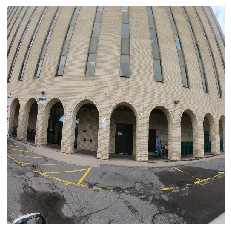

Billings Bridge Shopping Centre 2277 Riverside Drive 63.png
This image of building entrance is 95.84 percent accessible and 4.16 percent inaccessible.
✅ - This image has been correctly classified as accessible.



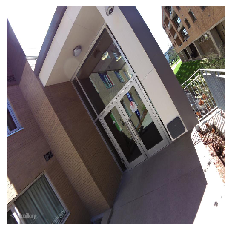

Glengarry House 1125 Colonel By Drive 37.png
This image of building entrance is 48.90 percent accessible and 51.10 percent inaccessible.
❌ - This image has been incorrectly classified as inaccessible.



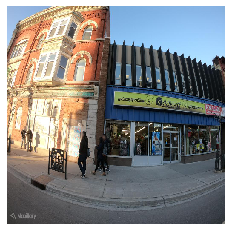

0568 5gjKjaLu72fZulzYn6dakA.png
This image of building entrance is 62.78 percent accessible and 37.22 percent inaccessible.
✅ - This image has been correctly classified as accessible.



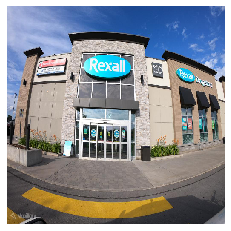

Staples 1595 Merivale Road 68.png
This image of building entrance is 99.51 percent accessible and 0.49 percent inaccessible.
✅ - This image has been correctly classified as accessible.



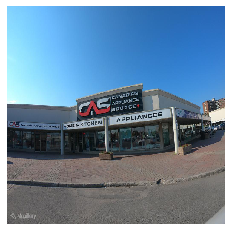

Ottawa Public Library - Emerald Plaza Branch 1547 Merivale Road 4.png
This image of building entrance is 63.28 percent accessible and 36.72 percent inaccessible.
✅ - This image has been correctly classified as accessible.



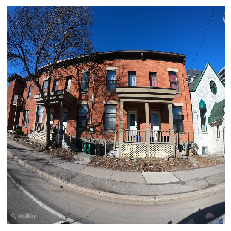

Meta Esthétique 250 A Lyon Street North 3.png
This image of building entrance is 5.56 percent accessible and 94.44 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



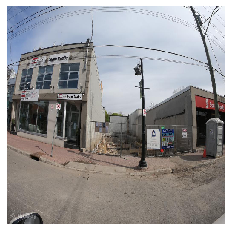

Scotiabank 388 Richmond Road 11.png
This image of building entrance is 91.59 percent accessible and 8.41 percent inaccessible.
❌ - This image has been incorrectly classified as accessible.



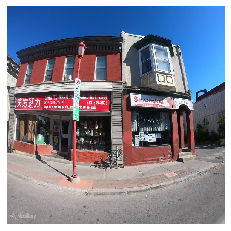

0096 olMK38JhuePHS_vVPQrYkw.png
This image of building entrance is 3.56 percent accessible and 96.44 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



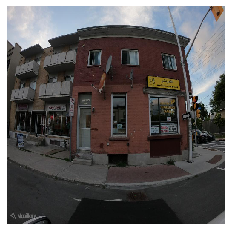

0077 X8w1Xk4VrfMbOqCxztCi3w.png
This image of building entrance is 2.93 percent accessible and 97.07 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



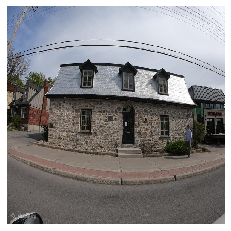

0042 kgZ8UZmcHMX6iYWQb05jcA.png
This image of building entrance is 28.71 percent accessible and 71.29 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



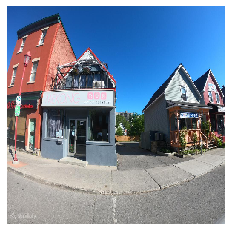

0087 xqF3ROA1jI2Z-7cSkyLxCQ.png
This image of building entrance is 9.66 percent accessible and 90.34 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



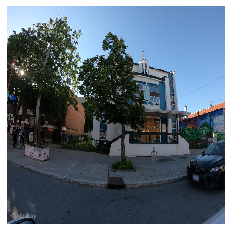

725 Somerset Street West 10.png
This image of building entrance is 30.46 percent accessible and 69.54 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



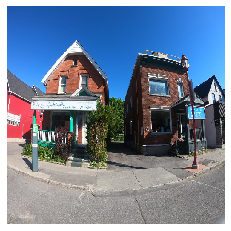

Jadeland Restaurant 625 Somerset Street West 0.png
This image of building entrance is 2.68 percent accessible and 97.32 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



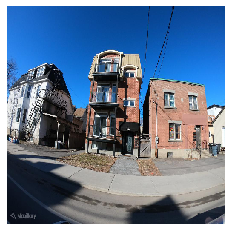

474 Lyon Street North 2.png
This image of building entrance is 11.91 percent accessible and 88.09 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.



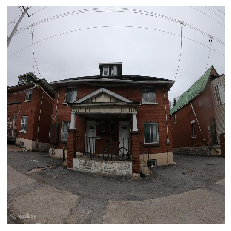

465 Catherine Street 13.png
This image of building entrance is 0.65 percent accessible and 99.35 percent inaccessible.
✅ - This image has been correctly classified as inaccessible.

8 of the 10 accessible images were correctly classified as accessible.
9 of the 10 inaccessible images were correctly classified as inaccessible.


In [ ]:
import os

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Accessible/'
correctInaccessible = 0
correctAccessible = 0

for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage),target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        plt.imshow(img)
        plt.axis("off")
        plt.pause(0.1)
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if((1 - score) > 0.5):
            print("✅ - This image has been correctly classified as accessible.\n")
            correctAccessible += 1
        elif ((1 - score) == 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as inaccessible.\n")

directory = r'./OSM_And_Mapillary_Sequence_Dataset/Test/Inaccessible/'
for testImage in os.listdir(directory):
    if testImage.endswith(".png"):
        #print(os.path.join(directory, testImage))
        img = keras.preprocessing.image.load_img(os.path.join(directory, testImage), 
                                                 target_size=image_size)
        img_array = keras.preprocessing.image.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)  # create batch axis

        predictions = model.predict(img_array)
        score = predictions[0]
        plt.imshow(img)
        plt.axis("off")
        plt.pause(0.1)
        print(testImage)
        print(
            "This image of building entrance is %.2f percent accessible and %.2f percent inaccessible."
            % (100 * (1 - score), 100 * score)
        )
        if(score > 0.5):
            print("✅ - This image has been correctly classified as inaccessible.\n")
            correctInaccessible += 1
        elif (score == 0.5):
            print("❓ - The model say this image has equal probability of being accesible or inaccessible.\n")
        else:
            print("❌ - This image has been incorrectly classified as accessible.\n")

print("%i of the 10 accessible images were correctly classified as accessible." % correctAccessible)
print("%i of the 10 inaccessible images were correctly classified as inaccessible." % correctInaccessible)
